In [25]:
"""
Data Compression  :  AutoEncoders
Data : Fashion Mnist
"""


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms,datasets
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim  # For real SSIM calculation



# Data Loading and Preprocessing

In [26]:
transform=transforms.Compose([transforms.ToTensor()])   # image to tensor

train_dataset=datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset=datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

batch_size=128

train_loader=DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size, shuffle=False)

# AutoEncoders

In [27]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super(AutoEncoder,self).__init__()
         # encoder
        self.encoder=nn.Sequential(
            nn.Flatten() ,   # ınput image (	(1, 1, 28, 28)) to vector 28*28 = 784
            nn.Linear(28*28,256),     # Input 784 to 256
            nn.ReLU(),
            nn.Linear(256,64),   # FCL
            nn.ReLU()
        )

        #decoder

        self.decoder=nn.Sequential(
            nn.Linear(64,256),
            nn.ReLU(),
            nn.Linear(256,28*28),
            nn.Sigmoid() ,     # Since tensor already compressed the dataset 0-1 and isgmoid is used.
            nn.Unflatten(1,(1,28,28))
        )

    
    def forward(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)

        return decoded

# CALLBACK : EARLY STOPPING 

In [28]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience        # Number of epochs to wait without improvement
        self.min_delta = min_delta      # Minimum change to qualify as improvement
        self.best_loss = None           # Best loss observed so far
        self.counter = 0                # Counts epochs with no sufficient improvement

    def __call__(self, loss):
        # Check if loss improved enough
        if self.best_loss is None or (self.best_loss - loss) > self.min_delta:
            self.best_loss = loss       # Update best loss
            self.counter = 0            # Reset counter on improvement
        else:
            self.counter += 1           # Increment if no improvement

        # Return True if no improvement for more than patience epochs
        return self.counter > self.patience


# MODEL TRAINING

In [29]:
# hyperparams

epochs=50
learning_rate=1e-3 

# model , loss , optimizer, early stopper

model= AutoEncoder()
criterion= nn.MSELoss()  # loss function
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
early_stopping=EarlyStopping(patience=5,min_delta=0.001) 


def training(model,train_loader,optimizer,criterion,early_stopping, epochs):
    model.train()
    
    for epoch in range(epochs):

        total_loss=0   #for each epoch
        for inputs,_ in train_loader:      # We dont need labels
            optimizer.zero_grad()
            outputs=model(inputs)
            loss=criterion(outputs,inputs)
            loss.backward() 
            optimizer.step()
            total_loss+= loss.item()

        avg_loss=total_loss/len(train_loader)
        print(f"Epoch{epoch+1}/{epochs}, Loss: {avg_loss:.3f}")

        if early_stopping(avg_loss):
            print(f"Early stopping at epoch {epoch+1}")
            break

training(model,train_loader,optimizer,criterion,early_stopping, epochs)




Epoch1/50, Loss: 0.034
Epoch2/50, Loss: 0.017
Epoch3/50, Loss: 0.015
Epoch4/50, Loss: 0.013
Epoch5/50, Loss: 0.012
Epoch6/50, Loss: 0.012
Epoch7/50, Loss: 0.011
Epoch8/50, Loss: 0.010
Epoch9/50, Loss: 0.010
Epoch10/50, Loss: 0.010
Epoch11/50, Loss: 0.009
Epoch12/50, Loss: 0.009
Epoch13/50, Loss: 0.009
Epoch14/50, Loss: 0.009
Epoch15/50, Loss: 0.009
Epoch16/50, Loss: 0.009
Epoch17/50, Loss: 0.009
Epoch18/50, Loss: 0.008
Early stopping at epoch 18


# MODEL TESTING

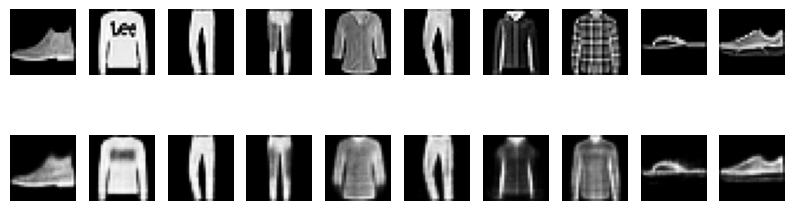

Average SSIM : 0.8422


In [32]:
def compute_ssim(img1, img2):
    data_range = img1.max() - img1.min()
    return ssim(img1, img2, data_range=data_range)

def evaluate(model, test_loader, n_images=10):
    model.eval()  # Set model to evaluation mode (no dropout, no batchnorm updates)

    with torch.no_grad():  # Disable gradient calculation (saves memory and computation)
        for batch in test_loader:
            inputs, _ = batch  # Load input images (we don't need labels)
            outputs = model(inputs)  # Get model predictions (reconstructed images)
            break  # Only process the first batch

    inputs = inputs.numpy()  # Convert input tensors to NumPy arrays
    outputs = outputs.numpy()  # Convert output tensors to NumPy arrays

    fig, axes = plt.subplots(2, n_images, figsize=(n_images, 3))  # Prepare 2-row plot layout
    ssim_scores = []  # Initialize list to store SSIM scores

    for i in range(n_images):
        img1 = np.squeeze(inputs[i])  # Remove extra dimensions from input image
        img2 = np.squeeze(outputs[i])  # Remove extra dimensions from output image

        ssim_score = compute_ssim(img1, img2)  # Calculate SSIM between input and output
        ssim_scores.append(ssim_score)  # Store SSIM score

        axes[0, i].imshow(img1, cmap="gray")  # Display original input image
        axes[0, i].axis("off")  # Hide axis ticks for cleaner look

        axes[1, i].imshow(img2, cmap="gray")  # Display reconstructed output image
        axes[1, i].axis("off")  # Hide axis ticks

    plt.show()  # Show the image comparison grid

    avg_ssim = np.mean(ssim_scores)  # Compute average SSIM across all image pairs
    print(f"Average SSIM : {avg_ssim:.4f}")  # Print average SSIM score



evaluate(model, test_loader, n_images=10)


Note: for future recommendation , Gaussian filter may apply to the images.